# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID v2.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers
- ``sample injection order.xlsx`` : File mapping the runs to the batch they were run in.

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

Output plots generated by running this notebook:

- `titer_cv.png`: image of all targets with their isoprenol production and %CV plotted
- `crispri_proteomics.png`: For several proteins, the distribution of all measurements in the library, the control strain, and the CRISPRi target strain
- `crispri_high_producers.png`: The above figure, but for the 20 highest producing targets used for selection.
- `target_filter_results.png`: For each CRISPRi target, a plot of their isoprenol titer and various measures of CRISPRi efficacy showing how CRISPRi filters remove specific targets.

## 1. Setup

### 1.1 Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
import utils
random.seed(1)

Define function for identifying if tests pass throughout the workbook: 

In [2]:
# def display_test_passage(condition, test_name):
#     color_image = np.zeros((1,1,3))
#     if condition: #green if true
#         color_index = 1
#         test_string = f'Test: {test_name} passed'
#     else: #red if false
#         color_index = 0
#         test_string = f'Test: {test_name} failed'

#     color_image[:, :, color_index] = 1
#     plt.figure(figsize = (2,2))
#     plt.imshow(color_image)
#     plt.axis('off')
#     print(test_string)
# display_test_passage('a' == 'a', 'sample test')

### 1.2 User parameters

In [3]:
user_params = {
    'output_dir'  : './DBTL0_results',
    'protein_map' : './DBTL0_data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./DBTL0_results/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./DBTL0_results/CRISPRi_triple_targets.csv',
    'run_list' : f'./DBTL0_data/sample injection order.xlsx',
    'n_instances_double': 30,
    'n_instances_triple': 30
}

ISOPRENOL_CODE = 'cid:12988'
PRODUCT = 'Isoprenol'

### 1.3 Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [4]:
study_slug_1 = 'crispri-automation-for-enhanced-isoprenol-pro-096d'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [5]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [6]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

  0%|          | 0/1033140 [00:00<?, ?it/s]

There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [7]:
df['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

## 2. Preprocess and inspect data

### 2.1 Useful functions - preprocessing

In [8]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

### 2.2 Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [9]:
df['Protocol']=='Biolector'

0          False
1          False
2          False
3          False
4          False
           ...  
1033135    False
1033136    False
1033137    False
1033138    False
1033139    False
Name: Protocol, Length: 1033140, dtype: bool

In [53]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [54]:
df2.shape

(1033140, 15)

Let's just keep the basic data types:

In [55]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [56]:
line_desc = df2['Line Description'].unique()
print(f'There are N = {len(line_desc)} unique line descriptions:')
print(line_desc)

There are N = 420 unique line descriptions:
['BL1A1_NT' 'BL4A1_NT' 'BL4B1_NT' 'BL4C1_NT' 'BL5A1_NT' 'BL5B1_NT'
 'BL5C1_NT' 'BL6A1_NT' 'BL6B1_NT' 'BL6C1_NT' 'BL1B1_NT' 'BL1C1_NT'
 'BL2A1_NT' 'BL2B1_NT' 'BL2C1_NT' 'BL3A1_NT' 'BL3B1_NT' 'BL3C1_NT'
 'BL5D7_IY2039' 'BL5E7_IY2039' 'BL5F7_IY2039' 'BL6A5_IY2043'
 'BL6B5_IY2043' 'BL6C5_IY2043' 'BL6A6_IY2044' 'BL6B6_IY2044'
 'BL6C6_IY2044' 'BL6A7_IY2045' 'BL6B7_IY2045' 'BL6C7_IY2045'
 'BL6A8_IY2046' 'BL6B8_IY2046' 'BL6C8_IY2046' 'BL4D5_IY2024'
 'BL4E5_IY2024' 'BL4F5_IY2024' 'BL8D3_IY2242' 'BL8E3_IY2242'
 'BL8F3_IY2242' 'BL8D2_IY2207' 'BL8E2_IY2207' 'BL8F2_IY2207'
 'BL8D1_IY2206' 'BL8E1_IY2206' 'BL8F1_IY2206' 'BL2A7_IY1660'
 'BL2B7_IY1660' 'BL2C7_IY1660' 'BL1A7_IY1591' 'BL1B7_IY1591'
 'BL1C7_IY1591' 'BL1A4_IY1588' 'BL1B4_IY1588' 'BL1C4_IY1588'
 'BL1A8_IY1592' 'BL1B8_IY1592' 'BL1C8_IY1592' 'BL4A6_IY1688'
 'BL4B6_IY1688' 'BL4C6_IY1688' 'BL4A7_IY1689' 'BL4B7_IY1689'
 'BL4C7_IY1689' 'BL2D2_IY1663' 'BL2E2_IY1663' 'BL2F2_IY1663'
 'BL3D1_IY1676' 'BL3E1_

In [57]:
line_name = df2['Line Name'].unique()
print(f'There are N = {len(line_name)} unique line descriptions:')
print(line_name)

There are N = 420 unique line descriptions:
['Control-R1' 'Control-R10' 'Control-R11' 'Control-R12' 'Control-R13'
 'Control-R14' 'Control-R15' 'Control-R16' 'Control-R17' 'Control-R18'
 'Control-R2' 'Control-R3' 'Control-R4' 'Control-R5' 'Control-R6'
 'Control-R7' 'Control-R8' 'Control-R9' 'PP_0001-R1' 'PP_0001-R2'
 'PP_0001-R3' 'PP_0103-R1' 'PP_0103-R2' 'PP_0103-R3' 'PP_0104-R1'
 'PP_0104-R2' 'PP_0104-R3' 'PP_0105-R1' 'PP_0105-R2' 'PP_0105-R3'
 'PP_0106-R1' 'PP_0106-R2' 'PP_0106-R3' 'PP_0168-R1' 'PP_0168-R2'
 'PP_0168-R3' 'PP_0225-R1' 'PP_0225-R2' 'PP_0225-R3' 'PP_0226-R1'
 'PP_0226-R2' 'PP_0226-R3' 'PP_0277-R1' 'PP_0277-R2' 'PP_0277-R3'
 'PP_0338-R1' 'PP_0338-R2' 'PP_0338-R3' 'PP_0362-R1' 'PP_0362-R2'
 'PP_0362-R3' 'PP_0368-R1' 'PP_0368-R2' 'PP_0368-R3' 'PP_0437-R1'
 'PP_0437-R2' 'PP_0437-R3' 'PP_0528-R1' 'PP_0528-R2' 'PP_0528-R3'
 'PP_0548-R1' 'PP_0548-R2' 'PP_0548-R3' 'PP_0582-R1' 'PP_0582-R2'
 'PP_0582-R3' 'PP_0597-R1' 'PP_0597-R2' 'PP_0597-R3' 'PP_0654-R1'
 'PP_0654-R2' 'PP_0654-

### Remove 'NT' lines
Some targets have multiple guide RNA - we will drop all but one.

In [121]:
df2.loc[:, 'has_NT'] = df2['Line Name'].apply(lambda x: 'NT' in x)

In [58]:
nt_line_names = [x for x in df2['Line Name'].unique() if 'NT' in x ]
nt_line_names_to_keep = (
    [f'PP_1607_NT1-R{i}' for i in [1,2,3]] +
    [f'PP_4194_NT2-R{i}' for i in [1,2,3]]
)
nt_line_names_to_drop = [ln for ln in nt_line_names if ln not in nt_line_names_to_keep]

print(f'Before dropping NT line names, df2.shape: {df2.shape}') 
# df2 = df2[~df2['Line Name'].isin(nt_line_names_to_drop)]
print(f'After dropping NT line names, df2.shape: {df2.shape}') 

Before dropping NT line names, df2.shape: (1033140, 6)
After dropping NT line names, df2.shape: (1033140, 6)


In [59]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|O85207|PHAG_PSEPK Phag',
       'sp|P00552|KKA2_KLEPN Neo', ..., 'sp|Q88RM6|Q88RM6_PSEPK Pp_0103',
       'sp|Q88RS8|Q88RS8_PSEPK Pp_0051', 'sp|Q88RV6|Q88RV6_PSEPK Pp_0023'],
      dtype=object)

Look at measurement protocols:

In [60]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

There is only one measurement type for the GC-FID protocol (isoprenol measurements).

In [61]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

In [65]:
'Control-R15'.split('-')

['Control', 'R15']

In [66]:
df2['line_name_norep'] = df2['Line Name'].apply(lambda x: x.split('-')[0])

In [67]:
df2['line_name_norep'].unique()

array(['Control', 'PP_0001', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106',
       'PP_0168', 'PP_0225', 'PP_0226', 'PP_0277', 'PP_0338', 'PP_0362',
       'PP_0368', 'PP_0437', 'PP_0528', 'PP_0548', 'PP_0582', 'PP_0597',
       'PP_0654', 'PP_0658', 'PP_0691', 'PP_0751', 'PP_0774', 'PP_0806',
       'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815', 'PP_0897', 'PP_0944',
       'PP_0999', 'PP_1023', 'PP_1031', 'PP_1157', 'PP_1240', 'PP_1251',
       'PP_1317', 'PP_1318', 'PP_1319', 'PP_1394', 'PP_1444', 'PP_1457',
       'PP_1506', 'PP_1607_NT1_xylS_Pm', 'PP_1607_NT1',
       'PP_1607_NT2_xylS_Pm', 'PP_1607_NT2', 'PP_1607_NT3_xylS_Pm',
       'PP_1607_NT3', 'PP_1607_NT4_xylS_Pm', 'PP_1607_NT4', 'PP_1610',
       'PP_1620', 'PP_1664', 'PP_1755', 'PP_1769', 'PP_1770', 'PP_1777',
       'PP_2095', 'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339',
       'PP_2471', 'PP_2589', 'PP_2925', 'PP_3071', 'PP_3122', 'PP_3123',
       'PP_3280', 'PP_3282', 'PP_3355', 'PP_3365', 'PP_3394', 'PP_3578',
  

### 2.2 Add strain name to dataframe using prebuilt function.

In [68]:
df2["Strain"] = create_strain_names(df2)
print(df2.shape)

(1033140, 8)


In [70]:
df2['Strain'].unique()

array(['NT', 'IY2039', 'IY2043', 'IY2044', 'IY2045', 'IY2046', 'IY2024',
       'IY2242', 'IY2207', 'IY2206', 'IY1660', 'IY1591', 'IY1588',
       'IY1592', 'IY1688', 'IY1689', 'IY1663', 'IY1676', 'IY2217',
       'IY2200', 'IY2058', 'IY2218', 'IY1590', 'IY2023', 'IY2187',
       'IY2188', 'IY2189', 'IY2190', 'IY2214', 'IY2215', 'IY2033',
       'IY2237', 'IY2034', 'IY1668', 'IY2191', 'IY2220', 'IY2047',
       'IY2048', 'IY2186', 'IY1669', 'IY1659', 'IY2204', 'IY2201',
       'IY1655', 'IY1597', 'IY1656', 'IY1452', 'IY1657', 'IY1658',
       'IY2195', 'IY2202', 'IY2035', 'IY2216', 'IY2193', 'IY2055',
       'IY1673', 'IY2239', 'IY2221', 'IY1589', 'IY1680', 'IY1685',
       'IY2222', 'IY1682', 'IY1593', 'IY2219', 'IY1662', 'IY1678',
       'IY1679', 'IY1681', 'IY1666', 'IY1664', 'IY1670', 'IY1661',
       'IY1674', 'IY1594', 'IY1665', 'IY1667', 'IY2223', 'IY2224',
       'IY2041', 'IY2040', 'IY2025', 'IY2026', 'IY2027', 'IY2028',
       'IY2029', 'IY2032', 'IY2031', 'IY2199', 'IY2198',

### 2.3 Bring out Uniprot names

In [72]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)
get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'
print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


<>:1: SyntaxWarning: invalid escape sequence '\|'
<>:1: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_237/796388095.py:1: SyntaxWarning: invalid escape sequence '\|'
  get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)


In [73]:
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain
0,Control-R1,BL1A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,177.33700,Control,NT
1,Control-R10,BL4A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,176.13507,Control,NT
2,Control-R11,BL4B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,192.63713,Control,NT
3,Control-R12,BL4C1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,202.70480,Control,NT
4,Control-R13,BL5A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,123.84653,Control,NT


In [22]:
print(df2.shape)

(966381, 7)


### 2.4 Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [74]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [75]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

### 2.5 Drop non-target proteins

In [76]:
dcas9_uniprot = 'Q99ZW2'
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
targets_in_mapping.append(dcas9_uniprot)
df2 = df2.drop(
                    index=df2[(~df2['Formal Type'].isin(targets_in_mapping)) &
                                  (df2['Protocol']=='Global Proteomics')].index)
print(df2.shape)

(42132, 8)


In [77]:
len(targets_in_mapping)

123

### 2.6 Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [78]:
uniprot_to_pp = {}
for index in ProtMapping_df.index:
    uniprot_to_pp[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]
uniprot_to_pp[dcas9_uniprot] = 'dCas9'

Do the translation:

In [79]:
proteomics_ind = df2['Protocol']=='Global Proteomics'
df2.loc[proteomics_ind,'Formal Type'] = df2.loc[proteomics_ind,'Formal Type'].apply(lambda x: uniprot_to_pp[x])

### 2.7 Add Target Gene
Add column with a target gene for each strain.

In [80]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
get_target_gene_teststring = 'PP_4549-R1'
print(f'To get target gene:\nInput string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

To get target gene:
Input string: PP_4549-R1, output: PP_4549


In [81]:
df2['Target'] = df2['Line Name'].apply(get_target_gene)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target
0,Control-R1,BL1A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,177.33700,Control,NT,Control
1,Control-R10,BL4A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,176.13507,Control,NT,Control
2,Control-R11,BL4B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,192.63713,Control,NT,Control
3,Control-R12,BL4C1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,202.70480,Control,NT,Control
4,Control-R13,BL5A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,123.84653,Control,NT,Control


### 2.8 Normalize based on batch

Proteomics for different strains were run in 3 separate batches, and there was batch-to-batch variation in the detector efficiency. There were control strains ran in each batch. Thus, we normalize each strain to the control strains in each batch.  
- Check to make sure each entry in df2['Line Name'] matches an entry in the order spreadsheet
- Pull out controls from each batch
- Get rid of proteins missing from controls
- Normalize each run by control mean
- Compare the distributions of normalized and unnormalized proteins

#### 2.8.1 Assign batches to measurements

Import order of runs.

In [82]:
df_order = pd.read_excel(user_params['run_list'])
df_order.head()

,Sample Name in order injected,Batch number
0,Control-R1,1
1,Control-R2,1
2,Control-R3,1
3,Control-R4,1
4,Control-R5,1


Make a sample->batch dictionary


In [83]:
batch_dict = dict(df_order.values)

Check that sample names match between EDD and spreadsheet

In [84]:
unique_sample_names_order = df_order['Sample Name in order injected'].unique().sort()
unique_sample_names_df2 = df2['Line Name'].unique().sort()
assert unique_sample_names_df2 == unique_sample_names_order, 'ERROR: Run order names do not match EDD names'

#### 2.8.2 Identify controls

We find the control strains by looking for the 'ontrol' string in the line name (using instead of 'Control' or 'control' to avoid capitalization issues), and we add the information as a new column:

In [85]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(utils.find_control)

Add experimental batch to dataframe.

In [86]:
find_batch = lambda x: batch_dict[x]
df2['Batch'] = df2['Line Name'].apply(find_batch)

In [87]:
df2.head(3)

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target,Control,Batch
0,Control-R1,BL1A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,177.33700,Control,NT,Control,True,1
1,Control-R10,BL4A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,176.13507,Control,NT,Control,True,2
2,Control-R11,BL4B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,192.63713,Control,NT,Control,True,2


Print the batch for each control - they aren't uniformly distributed.

In [88]:
for ii in df2['Batch'].unique():
    print(f'Controls in batch {ii}: {df2[(df2["Batch"] == ii) & (df2["Control"])]["Line Name"].unique()}')

Controls in batch 1: ['Control-R1' 'Control-R2' 'Control-R3' 'Control-R4' 'Control-R5'
 'Control-R6' 'Control-R7']
Controls in batch 2: ['Control-R10' 'Control-R11' 'Control-R12' 'Control-R13' 'Control-R14'
 'Control-R8' 'Control-R9']
Controls in batch 3: ['Control-R15' 'Control-R16' 'Control-R17' 'Control-R18']


In [98]:
print(df2.value_counts(['line_name_norep', 'Batch']).iloc[:60])

line_name_norep  Batch
Control          2        700
                 1        693
PP_0812          3        606
PP_0813          3        606
Control          3        404
PP_4043          3        303
PP_4160          3        303
PP_4159          3        303
PP_4128          3        303
PP_4123          3        303
PP_4120          3        303
PP_4119          3        303
PP_4116          3        303
PP_4012          3        303
PP_4174          3        303
PP_4011          3        303
PP_2925          3        303
PP_2339          3        303
PP_2112          3        303
PP_2095          3        303
PP_1769          3        303
PP_1755          3        303
PP_1620          3        303
PP_4161          3        303
PP_4175          3        303
PP_1607_NT1      3        303
PP_4185          3        303
PP_5416          3        303
PP_5203          3        303
PP_5186          3        303
PP_5128          3        303
PP_5064          3        303
PP_4862          

In [99]:
print(df2.value_counts(['line_name_norep', 'Batch']).iloc[61:120])

line_name_norep      Batch
PP_0106              3        303
PP_0105              3        303
PP_1457              3        303
PP_0104              3        303
PP_0103              3        303
PP_0658              3        303
PP_0815              3        303
PP_0001              3        303
PP_0814              3        303
PP_0751              3        303
PP_0226              3        303
PP_3578              2        300
PP_4487              2        300
PP_0597              2        300
PP_0528              2        300
PP_0548              2        300
PP_0806              2        300
PP_4636              2        300
PP_2471              2        300
PP_4667              2        300
PP_4679              2        300
PP_5419              2        300
PP_5417              2        300
PP_5335              2        300
PP_5288              2        300
PP_4894              2        300
PP_0168              2        300
PP_4737              2        300
PP_4702              

In [101]:
df2.loc[df2['line_name_norep'] == 'PP_1607_NT4']

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target,Control,Batch
174,PP_1607_NT4-R1,BL1D6_IY1452_pIY1081,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.651835e+02,PP_1607_NT4,IY1452,PP_1607,False,1
175,PP_1607_NT4-R2,BL1E6_IY1452_pIY1081,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.334485e+02,PP_1607_NT4,IY1452,PP_1607,False,1
176,PP_1607_NT4-R3,BL1F6_IY1452_pIY1081,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.498265e+02,PP_1607_NT4,IY1452,PP_1607,False,1
1622,PP_1607_NT4-R1,BL1D6_IY1452_pIY1081,Global Proteomics,PP_2471,Integration host factor subunit alpha,3.357079e+06,PP_1607_NT4,IY1452,PP_1607,False,1
1623,PP_1607_NT4-R2,BL1E6_IY1452_pIY1081,Global Proteomics,PP_2471,Integration host factor subunit alpha,3.378747e+06,PP_1607_NT4,IY1452,PP_1607,False,1
...,...,...,...,...,...,...,...,...,...,...,...
230199,PP_1607_NT4-R2,BL1E6_IY1452_pIY1081,Global Proteomics,PP_0168,Putative surface adhesion protein,1.222492e+07,PP_1607_NT4,IY1452,PP_1607,False,1
230200,PP_1607_NT4-R3,BL1F6_IY1452_pIY1081,Global Proteomics,PP_0168,Putative surface adhesion protein,9.197211e+06,PP_1607_NT4,IY1452,PP_1607,False,1
237014,PP_1607_NT4-R1,BL1D6_IY1452_pIY1081,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,2.425405e+05,PP_1607_NT4,IY1452,PP_1607,False,1
237015,PP_1607_NT4-R2,BL1E6_IY1452_pIY1081,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,7.380912e+05,PP_1607_NT4,IY1452,PP_1607,False,1


#### 2.8.3 Drop proteins with missing controls
Some proteins have missing measurements in one or more batches, so we can't normalize them.

Check how many different analytes are measured in controls.

In [102]:
print(f'There are {len(df2.loc[df2["Control"], "Measurement Type"].unique())} unique analytes in the control dataframe')

There are 97 unique analytes in the control dataframe


Create pivot table based on batch number. 

In [103]:
control_batch_pivot = pd.pivot_table(df2[df2['Control']], values = 'Value', columns = 'Batch', index = 'Formal Type', aggfunc = 'mean')
control_batch_pivot.head(3)

Batch,1,2,3
Formal Type,,,
PP_0001,5.382129e+06,3.827842e+06,2.740936e+06
PP_0103,NaN,NaN,1.723723e+04
PP_0168,9.470668e+06,1.091311e+07,5.121947e+06


Check for NaN measurements in control runs. 

In [104]:
print(f'There are: {sum(control_batch_pivot.isna())} NaNs in measurement pivot table')

There are: 6 NaNs in measurement pivot table


In [105]:
any_measurement_missing = np.where(np.any(control_batch_pivot.isna(), 1))
control_batch_pivot.iloc[any_measurement_missing][:]

Batch,1,2,3
Formal Type,,,
PP_0103,NaN,NaN,17237.2300
PP_0225,NaN,6933.567143,4309.3075
PP_0548,NaN,NaN,4309.3075
PP_4650,16068.194286,13867.134286,NaN


Get measurement types that have all their control values. 

In [106]:
control_batch_pivot = control_batch_pivot.dropna() 
list_of_control_type = control_batch_pivot.index.values.tolist()
check_norm_exist = lambda x: x in list_of_control_type
df2.loc[:, 'can_normalize'] = df2['Formal Type'].apply(check_norm_exist)
df2.head(3)

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target,Control,Batch,can_normalize
0,Control-R1,BL1A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,177.33700,Control,NT,Control,True,1,True
1,Control-R10,BL4A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,176.13507,Control,NT,Control,True,2,True
2,Control-R11,BL4B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,192.63713,Control,NT,Control,True,2,True


Drop measurements that can't be normalized. 

In [107]:
df2 = df2[df2['can_normalize'] == 1]
df2.shape

(41160, 12)

#### 2.8.4. Normalize runs by batch

Need to divide each measurement the correct batch control mean. Create column for holding the control mean and fill it in with lambda function.

In [108]:
df2.loc[:, 'control_mean'] = np.nan
#Iterate through batch numbers [1,2,3]
for ii in [1,2,3]:
    add_correct_normalization_value = lambda x: control_batch_pivot[ii][x]
    current_batch_idx = df2['Batch'] == ii
    df2.loc[current_batch_idx, 'control_mean'] = df2[current_batch_idx]['Formal Type'].apply(add_correct_normalization_value)

/tmp/ipykernel_237/975866193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'control_mean'] = np.nan


Add column to dataframe and fill it with normalized values. Don't normalize isoprenol since it was not affected by batch variation. Isoprenol was measured using GC, not mass spec.

In [109]:
df2.loc[:, 'norm_value'] = np.nan
index_to_normalize = df2['Protocol'] == 'Global Proteomics'
index_not_normalized = df2['Protocol'] != 'Global Proteomics'
df2.loc[index_to_normalize, 'norm_value'] = df2.loc[index_to_normalize, 'Value']/df2.loc[index_to_normalize, 'control_mean']
df2.loc[index_not_normalized, 'norm_value'] = df2.loc[index_not_normalized, 'Value']
df2.head(3)

/tmp/ipykernel_237/1480012787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'norm_value'] = np.nan


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target,Control,Batch,can_normalize,control_mean,norm_value
0,Control-R1,BL1A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,177.33700,Control,NT,Control,True,1,True,164.453763,177.33700
1,Control-R10,BL4A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,176.13507,Control,NT,Control,True,2,True,171.941151,176.13507
2,Control-R11,BL4B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,192.63713,Control,NT,Control,True,2,True,171.941151,192.63713


### 2.9 Visualize normalization effects

#### 2.9.1 Functions for visualizing batch effects

Functions generate swarm plots grouped by batch with individual datapoints represented by blue dots and the mean of each group down with a red dash.

In [110]:
def compare_swarm(df, measurement_type, batches, ax = None, to_plot = 'Value'):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(batches), 5))
    df = df[df['Batch'].isin(batches)]
    sns.stripplot(df[df['Measurement Type'] == measurement_type], x = 'Batch', y = to_plot, alpha = 0.5)
    
    #Add mean as red dot
    mean_vals = [np.mean(df[(df['Measurement Type'] == measurement_type) & (df['Batch'] == batch_num)][to_plot]) for batch_num in batches]
                    
    [ax.scatter(i, mean_vals[i], color = 'red', marker = '_', s = 100, zorder = 10) for i in range(len(batches))]
    plt.title(measurement_type)

def compare_swarm_multi(df, measurement_type, batches, to_plot = 'Value'):
    n_measures = len(measurement_type)
    fig = plt.figure(figsize=(15, 5*np.ceil(len(measurement_type)/6)))
    fig.subplots_adjust(hspace=0.3, wspace=0.6)
    #fig.suptitle('Comparing batches')
    
    for ii, m in enumerate(measurement_type):
        ax = fig.add_subplot(int(np.ceil(len(measurement_type)/6)), 6, (ii+1))
        compare_swarm(df, m, batches, ax, to_plot = to_plot)
        ax.set_title(m.replace(' ', '\n', 1))
    return fig

This function plots the distribution of differences between different batches of data for all proteins in the dataset.

In [111]:
def plot_distribution_of_differences(meas_pivot, comparisons, labels):
    """
    Take a pivot table of measurements in and plot distributions of comparisons between batches.
    """
    n_comparisons = len(comparisons)
    fig, ax = plt.subplots(nrows = 1, ncols = n_comparisons)
    for ii in range(n_comparisons):
        dif_current = meas_pivot[comparisons[ii][0]] - meas_pivot[comparisons[ii][1]]
        sns.histplot(dif_current, ax = ax[ii])
        ax[ii].set_xlabel(labels[ii])
    return fig, ax       

#### 2.9.2 Swarmplots of controls
Plot the measurements of individual controls (blue dots) and the batch mean of the control (red line) between batches using a swarm plot. 

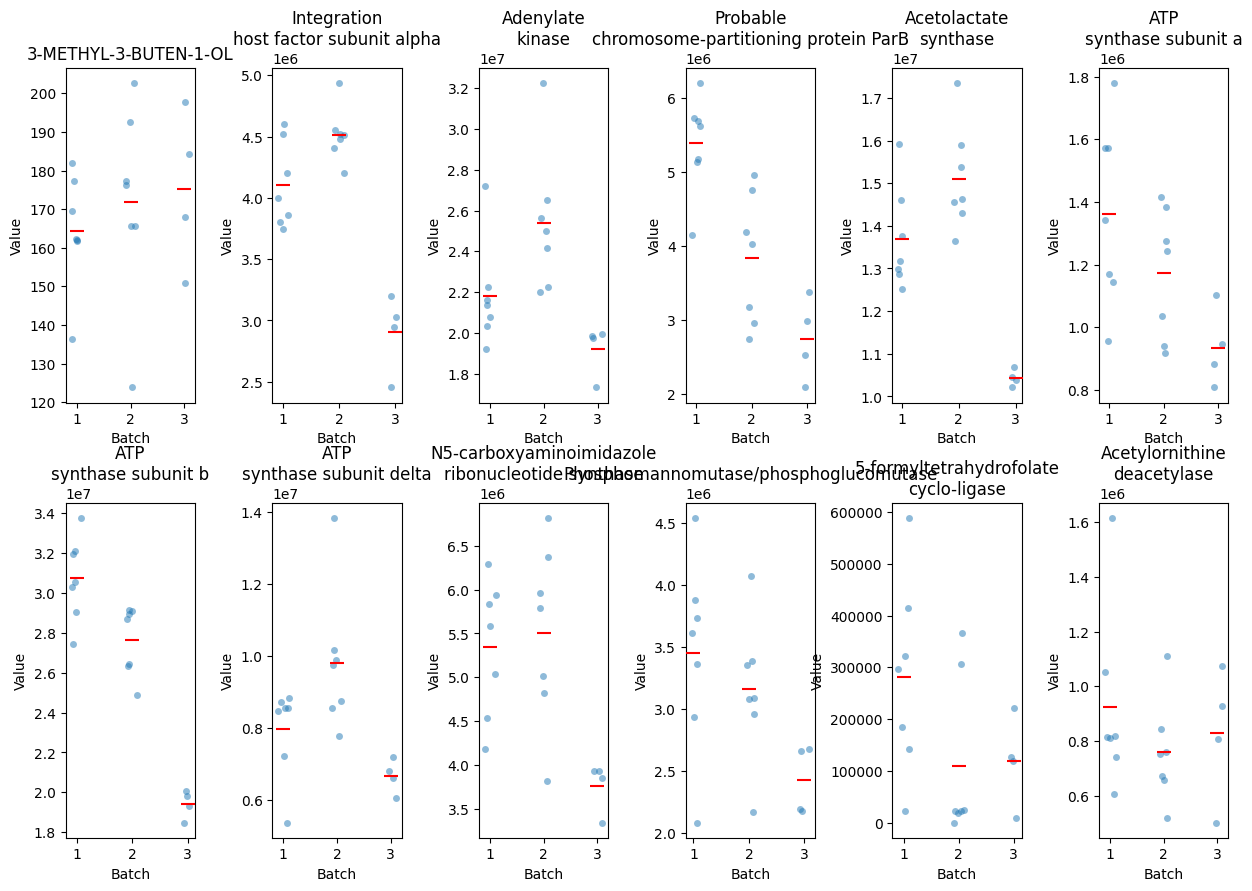

In [112]:
target_list_all = df2[df2['Control']]['Measurement Type'].unique().tolist()
control_swarm_fig = compare_swarm_multi(df2[df2['Control']], target_list_all[:12], [1,2,3])

#### 2.9.3 Distribution of differences
Calculating change in counts for (batch 3) - (batch 1) should skew negative for unnormalized data, but should go away with normalization.

Make pivot tables for normalized an unnormalized data and set up labels. 

In [113]:
proteomics_control_batch_means = pd.pivot_table(df2[df2['Control']], values = ['Value', 'norm_value'], columns = 'Batch', index = 'Measurement Type', aggfunc = 'mean')
proteomics_control_batch_means_ft = pd.pivot_table(df2[df2['Control']], values = ['Value', 'norm_value'], columns = 'Batch', index = 'Formal Type', aggfunc = 'mean')
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['Batch 3 - Batch 1',
              'Batch 2 - Batch 1']
proteomics_control_batch_means

Value  \
Batch                                                          1   
Measurement Type                                                   
3-METHYL-3-BUTEN-1-OL                               1.644538e+02   
3-hydroxy acid dehydrogenase, NADP-dependent / ...  4.523416e+06   
3-hydroxybutyryl-CoA dehydrogenase                  6.215039e+05   
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...  1.074932e+07   
3-ketoacyl-CoA thiolase                             3.633296e+06   
...                                                          ...   
Thiolase family protein                             7.354945e+04   
Ubiquinol oxidase subunit 2                         1.050896e+07   
Ubiquinol oxidase subunit I, cyanide insensitive    3.204960e+05   
Ubiquinol--cytochrome c reductase, cytochrome c1    6.465339e+06   
Ubiquinol-cytochrome c reductase iron-sulfur su...  7.060612e+06   

                                                                  \
Batch                                                          2   
Measurement Type                                                   
3-METHYL-3-BUTEN-1-OL                               1.719412e+02   
3-hydroxy acid dehydrogenase, NADP-dependent / ...  4.162383e+06   
3-hydroxybutyryl-CoA dehydrogenase                  5.696421e+05   
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...  9.631210e+06   
3-ketoacyl-CoA thiolase                             3.007574e+06   
...                                                          ...   
Thiolase family protein                             1.776669e+05   
Ubiquinol oxidase subunit 2                         8.298769e+06   
Ubiquinol oxidase subunit I, cyanide insensitive    1.209153e+05   
Ubiquinol--cytochrome c reductase, cytochrome c1    6.073736e+06   
Ubiquinol-cytochrome c reductase iron-sulfur su...  6.081083e+06   

                                                                  norm_value  \
Batch                                                          3           1   
Measurement Type                                                               
3-METHYL-3-BUTEN-1-OL                               1.752550e+02  164.453763   
3-hydroxy acid dehydrogenase, NADP-dependent / ...  3.047278e+06    1.000000   
3-hydroxybutyryl-CoA dehydrogenase                  3.762857e+05    1.000000   
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...  7.542387e+06    1.000000   
3-ketoacyl-CoA thiolase                             2.349939e+06    1.000000   
...                                                          ...         ...   
Thiolase family protein                             2.609343e+05    1.000000   
Ubiquinol oxidase subunit 2                         8.097839e+06    1.000000   
Ubiquinol oxidase subunit I, cyanide insensitive    3.448670e+05    1.000000   
Ubiquinol--cytochrome c reductase, cytochrome c1    4.071625e+06    1.000000   
Ubiquinol-cytochrome c reductase iron-sulfur su...  3.269404e+06    1.000000   

                                                                            
Batch                                                        2           3  
Measurement Type                                                            
3-METHYL-3-BUTEN-1-OL                               171.941151  175.254983  
3-hydroxy acid dehydrogenase, NADP-dependent / ...    1.000000    1.000000  
3-hydroxybutyryl-CoA dehydrogenase                    1.000000    1.000000  
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...    1.000000    1.000000  
3-ketoacyl-CoA thiolase                               1.000000    1.000000  
...                                                        ...         ...  
Thiolase family protein                               1.000000    1.000000  
Ubiquinol oxidase subunit 2                           1.000000    1.000000  
Ubiquinol oxidase subunit I, cyanide insensitive      1.000000    1.000000  
Ubiquinol--cytochrome c reductase, cytochrome c1      1.000000    1.000000  
Ubiquinol-cytochrome c reductas

Make plots to show the distribution of differences. 

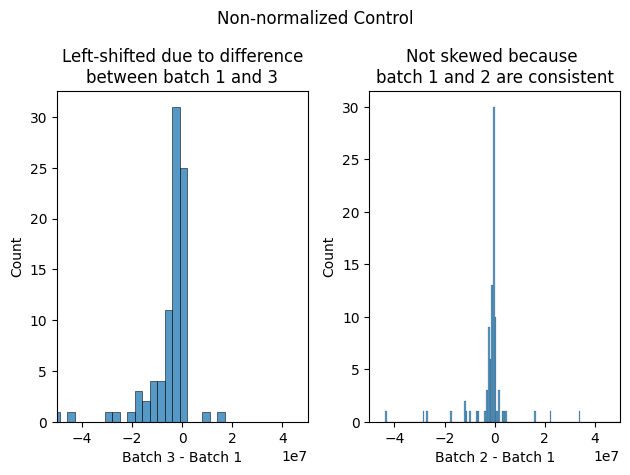

In [114]:
fig, ax = plot_distribution_of_differences(proteomics_control_batch_means['Value'], dif_to_plot, dif_labels)
ax_lim = 5e7
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
ax[0].set_title('Left-shifted due to difference\nbetween batch 1 and 3')
ax[1].set_title('Not skewed because \nbatch 1 and 2 are consistent')

fig.suptitle('Non-normalized Control')
fig.tight_layout()

#### 2.9.4 Swarmplots for all proteins
These swarmplots compare the distribution of all proteins in each batch before and after normalization. We can see that the normalization makes the difference in distributions much less. 



Text(0.5, 0.98, 'Normalized Proteomics - all lines')

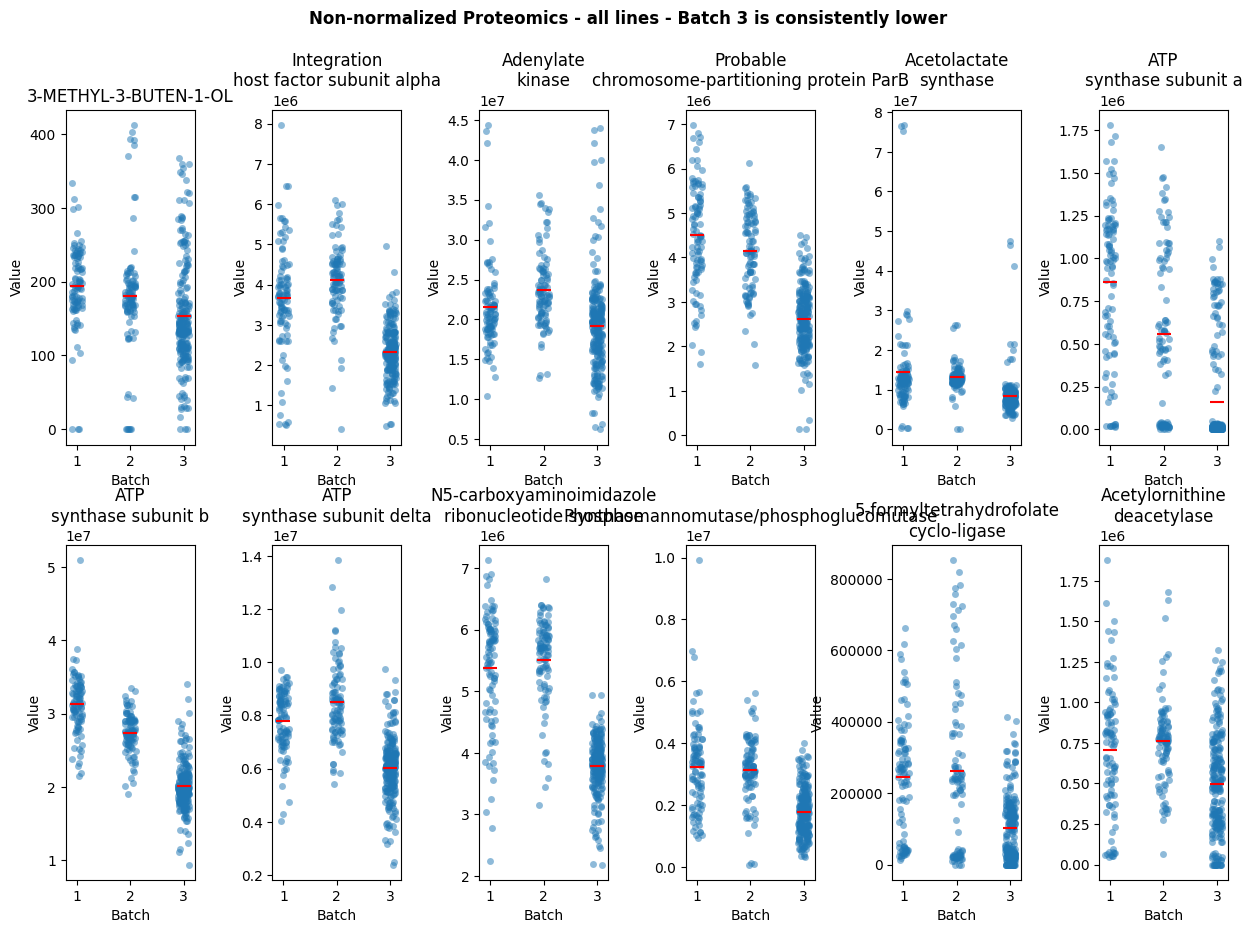

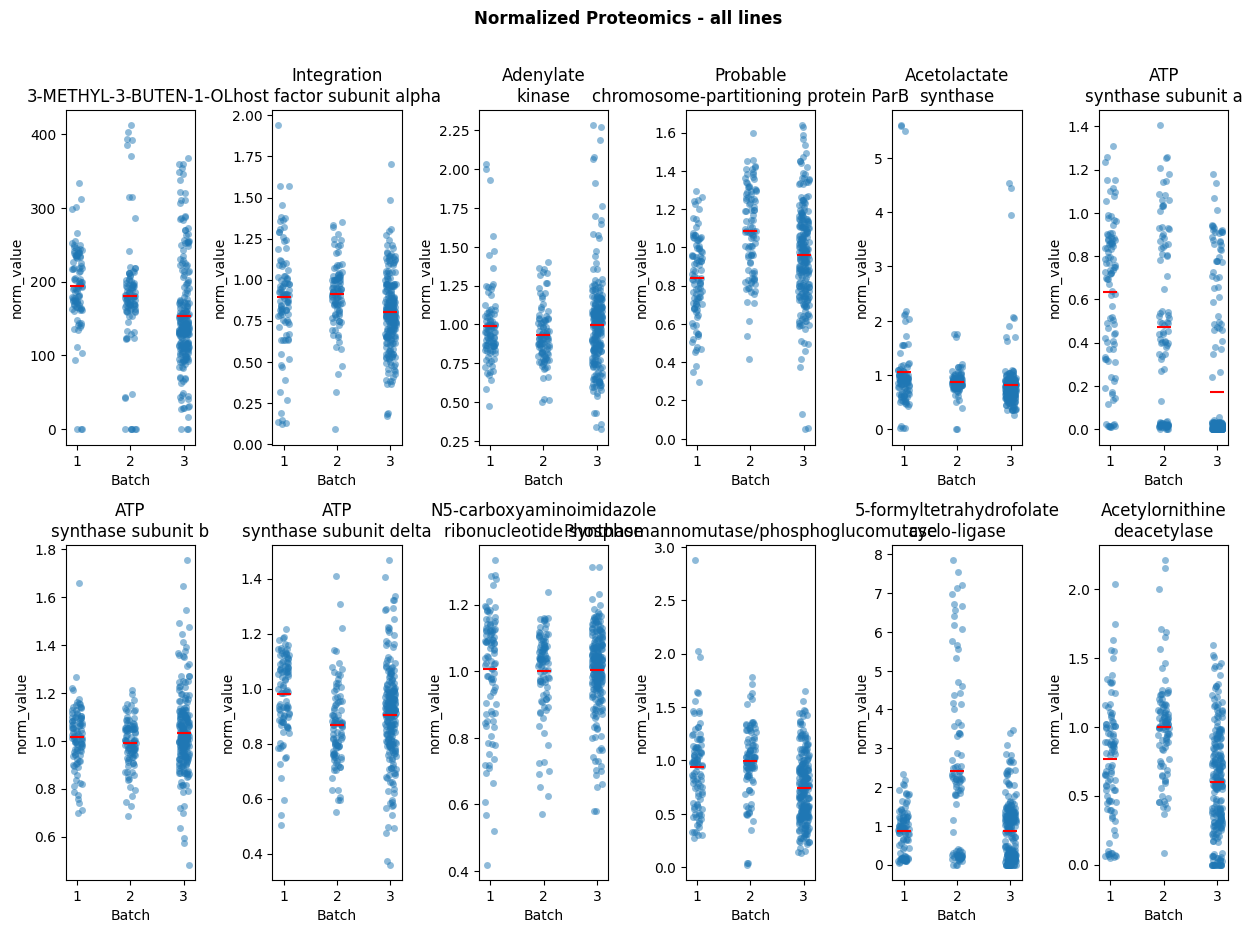

In [115]:
target_list_filter = df2['Measurement Type'].unique().tolist()
unnorm_fig = compare_swarm_multi(df2, target_list_filter[:12], [1,2,3], to_plot='Value')
unnorm_fig.suptitle('Non-normalized Proteomics - all lines - Batch 3 is consistently lower', fontweight = 'bold')
norm_fig = compare_swarm_multi(df2, target_list_filter[:12], [1,2,3], to_plot='norm_value')
norm_fig.suptitle('Normalized Proteomics - all lines', fontweight = 'bold')

Create a copy of df2 to use later

In [116]:
df2_freeze = df2.copy(deep = True)

In [118]:
df2['line_name_norep'].unique()

array(['Control', 'PP_0001', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106',
       'PP_0168', 'PP_0225', 'PP_0226', 'PP_0277', 'PP_0338', 'PP_0362',
       'PP_0368', 'PP_0437', 'PP_0528', 'PP_0548', 'PP_0582', 'PP_0597',
       'PP_0654', 'PP_0658', 'PP_0691', 'PP_0751', 'PP_0774', 'PP_0806',
       'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815', 'PP_0897', 'PP_0944',
       'PP_0999', 'PP_1023', 'PP_1031', 'PP_1157', 'PP_1240', 'PP_1251',
       'PP_1317', 'PP_1318', 'PP_1319', 'PP_1394', 'PP_1444', 'PP_1457',
       'PP_1506', 'PP_1607_NT1_xylS_Pm', 'PP_1607_NT1',
       'PP_1607_NT2_xylS_Pm', 'PP_1607_NT2', 'PP_1607_NT3_xylS_Pm',
       'PP_1607_NT3', 'PP_1607_NT4_xylS_Pm', 'PP_1607_NT4', 'PP_1610',
       'PP_1620', 'PP_1664', 'PP_1755', 'PP_1769', 'PP_1770', 'PP_1777',
       'PP_2095', 'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339',
       'PP_2471', 'PP_2589', 'PP_2925', 'PP_3071', 'PP_3122', 'PP_3123',
       'PP_3280', 'PP_3282', 'PP_3355', 'PP_3365', 'PP_3394', 'PP_3578',
  

In [124]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target,Control,Batch,can_normalize,control_mean,norm_value,has_NT
0,Control-R1,BL1A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,177.33700,Control,NT,Control,True,1,True,1.644538e+02,177.337000,False
1,Control-R10,BL4A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,176.13507,Control,NT,Control,True,2,True,1.719412e+02,176.135070,False
2,Control-R11,BL4B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,192.63713,Control,NT,Control,True,2,True,1.719412e+02,192.637130,False
3,Control-R12,BL4C1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,202.70480,Control,NT,Control,True,2,True,1.719412e+02,202.704800,False
4,Control-R13,BL5A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,123.84653,Control,NT,Control,True,2,True,1.719412e+02,123.846530,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032679,PP_5416-R2,BL10B5_IY2022,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,469187.37000,PP_5416,IY2022,PP_5416,False,3,True,7.902241e+06,0.059374,False
1032680,PP_5416-R3,BL10C5_IY2022,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,0.00000,PP_5416,IY2022,PP_5416,False,3,True,7.902241e+06,0.000000,False
1032681,PP_5420-R1,BL10A4_IY2019,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,238334.18000,PP_5420,IY2019,PP_5420,False,3,True,7.902241e+06,0.030160,False
1032682,PP_5420-R2,BL10B4_IY2019,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,296369.78000,PP_5420,IY2019,PP_5420,False,3,True,7.902241e+06,0.037505,False


In [126]:
df2.loc[df2['line_name_norep'].str.contains('4194')]

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target,Control,Batch,can_normalize,control_mean,norm_value,has_NT
333,PP_4194_NT2-R1,BL1D3_IY1595,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.658196e+02,PP_4194_NT2,IY1595,PP_4194,False,1,True,1.644538e+02,265.819600,True
334,PP_4194_NT2-R2,**BL1E3_IY1595,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.012338e+02,PP_4194_NT2,IY1595,PP_4194,False,1,True,1.644538e+02,301.233800,True
335,PP_4194_NT2-R3,BL1F3_IY1595,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.460425e+02,PP_4194_NT2,IY1595,PP_4194,False,1,True,1.644538e+02,246.042470,True
336,PP_4194_NT3-R1,BL1D4_IY1596,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.982508e+02,PP_4194_NT3,IY1596,PP_4194,False,1,True,1.644538e+02,298.250800,True
337,PP_4194_NT3-R2,BL1E4_IY1596,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.334197e+02,PP_4194_NT3,IY1596,PP_4194,False,1,True,1.644538e+02,333.419730,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237049,PP_4194_NT2-R2,**BL1E3_IY1595,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,5.859280e+05,PP_4194_NT2,IY1595,PP_4194,False,1,True,2.322422e+07,0.025229,True
237050,PP_4194_NT2-R3,BL1F3_IY1595,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,8.021496e+05,PP_4194_NT2,IY1595,PP_4194,False,1,True,2.322422e+07,0.034539,True
237051,PP_4194_NT3-R1,BL1D4_IY1596,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,3.050348e+06,PP_4194_NT3,IY1596,PP_4194,False,1,True,2.322422e+07,0.131343,True
237052,PP_4194_NT3-R2,BL1E4_IY1596,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,6.181860e+06,PP_4194_NT3,IY1596,PP_4194,False,1,True,2.322422e+07,0.266182,True


In [129]:
df2['Formal Type'].unique()

array(['cid:12988', 'PP_2471', 'PP_1506', 'PP_0001', 'PP_3365', 'PP_5419',
       'PP_5417', 'PP_5416', 'PP_5335', 'PP_5288', 'PP_5203', 'PP_5186',
       'PP_5128', 'PP_5064', 'PP_4894', 'PP_4862', 'PP_4702', 'PP_4679',
       'PP_4678', 'PP_4667', 'PP_4651', 'PP_4636', 'PP_4635', 'PP_4550',
       'PP_4549', 'PP_4487', 'PP_4266', 'PP_4194', 'PP_4193', 'PP_4192',
       'PP_4191', 'PP_4190', 'PP_4189', 'PP_4188', 'PP_4187', 'PP_4186',
       'PP_4185', 'PP_4175', 'PP_4174', 'PP_4130', 'PP_4129', 'PP_4123',
       'PP_4122', 'PP_4121', 'PP_4120', 'PP_4119', 'PP_4116', 'PP_4012',
       'PP_4011', 'PP_3755', 'PP_3754', 'PP_3578', 'PP_3123', 'PP_3122',
       'PP_3071', 'PP_2925', 'PP_2339', 'PP_2213', 'PP_2137', 'PP_2136',
       'PP_2112', 'PP_2095', 'PP_1777', 'PP_1770', 'PP_1769', 'PP_1755',
       'PP_1664', 'PP_1620', 'PP_1610', 'PP_1607', 'PP_1457', 'PP_1444',
       'PP_1319', 'PP_1318', 'PP_1317', 'PP_1251', 'PP_1240', 'PP_1031',
       'PP_1023', 'PP_0999', 'PP_0944', 'PP_0897'

In [147]:
df2.loc[(df2['Formal Type'].isin(['cid:12988', 'dCas9', 'PP_4194'])) & (df2['line_name_norep'].str.contains('4194')), :]


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,line_name_norep,Strain,Target,Control,Batch,can_normalize,control_mean,norm_value,has_NT
333,PP_4194_NT2-R1,BL1D3_IY1595,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.658196e+02,PP_4194_NT2,IY1595,PP_4194,False,1,True,1.644538e+02,265.819600,True
334,PP_4194_NT2-R2,**BL1E3_IY1595,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.012338e+02,PP_4194_NT2,IY1595,PP_4194,False,1,True,1.644538e+02,301.233800,True
335,PP_4194_NT2-R3,BL1F3_IY1595,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.460425e+02,PP_4194_NT2,IY1595,PP_4194,False,1,True,1.644538e+02,246.042470,True
336,PP_4194_NT3-R1,BL1D4_IY1596,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.982508e+02,PP_4194_NT3,IY1596,PP_4194,False,1,True,1.644538e+02,298.250800,True
337,PP_4194_NT3-R2,BL1E4_IY1596,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.334197e+02,PP_4194_NT3,IY1596,PP_4194,False,1,True,1.644538e+02,333.419730,True
338,PP_4194_NT3-R3,BL1F4_IY1596,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.114637e+02,PP_4194_NT3,IY1596,PP_4194,False,1,True,1.644538e+02,311.463670,True
71736,PP_4194_NT2-R1,BL1D3_IY1595,Global Proteomics,PP_4194,Citrate synthase,4.303630e+07,PP_4194_NT2,IY1595,PP_4194,False,1,True,5.285085e+07,0.814297,True
71737,PP_4194_NT2-R2,**BL1E3_IY1595,Global Proteomics,PP_4194,Citrate synthase,5.344170e+07,PP_4194_NT2,IY1595,PP_4194,False,1,True,5.285085e+07,1.011179,True
71738,PP_4194_NT2-R3,BL1F3_IY1595,Global Proteomics,PP_4194,Citrate synthase,5.590376e+07,PP_4194_NT2,IY1595,PP_4194,False,1,True,5.285085e+07,1.057764,True
71739,PP_4194_NT3-R1,BL1D4_IY1596,Global Proteomics,PP_4194,Citrate synthase,3.257890e+07,PP_4194_NT3,IY1596,PP_4194,False,1,True,5.285085e+07,0.616431,True


In [160]:
[x for x in df2['Line Name'].unique() if '4194' in x]

['PP_4194_NT2-R1',
 'PP_4194_NT2-R2',
 'PP_4194_NT2-R3',
 'PP_4194_NT3-R1',
 'PP_4194_NT3-R2',
 'PP_4194_NT3-R3']

<Axes: xlabel='norm_value', ylabel='line_name_norep'>

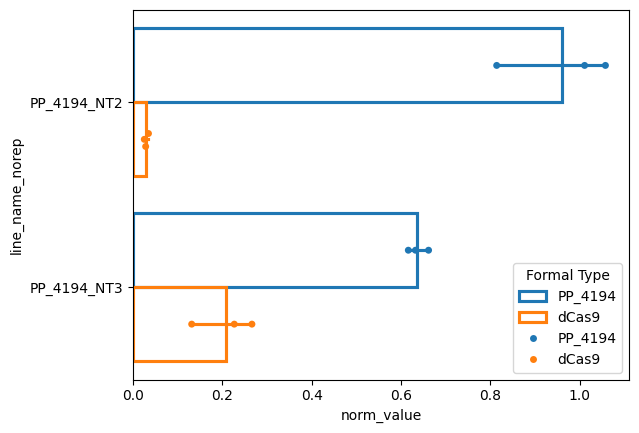

In [154]:
sns.barplot(
    data = df2.loc[(df2['Formal Type'].isin([ 'dCas9', 'PP_4194'])) & (df2['line_name_norep'].str.contains('4194')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    fill = False
)
sns.swarmplot(
    data = df2.loc[(df2['Formal Type'].isin([ 'dCas9', 'PP_4194'])) & (df2['line_name_norep'].str.contains('4194')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    dodge = True
)

<Axes: xlabel='norm_value', ylabel='line_name_norep'>

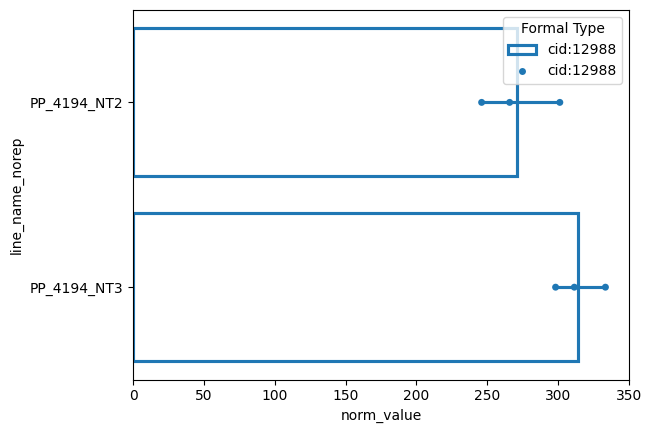

In [155]:
sns.barplot(
    data = df2.loc[(df2['Formal Type'].isin(['cid:12988'])) & (df2['line_name_norep'].str.contains('4194')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    fill = False
)
sns.swarmplot(
    data = df2.loc[(df2['Formal Type'].isin(['cid:12988'])) & (df2['line_name_norep'].str.contains('4194')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    dodge = True
)

In [165]:
nt_df= df2.loc[df2['has_NT'], :]

nt_df['line_name_norep'].unique()

array(['PP_1607_NT1_xylS_Pm', 'PP_1607_NT1', 'PP_1607_NT2_xylS_Pm',
       'PP_1607_NT2', 'PP_1607_NT3_xylS_Pm', 'PP_1607_NT3',
       'PP_1607_NT4_xylS_Pm', 'PP_1607_NT4', 'PP_4194_NT2', 'PP_4194_NT3'],
      dtype=object)

<Axes: xlabel='norm_value', ylabel='line_name_norep'>

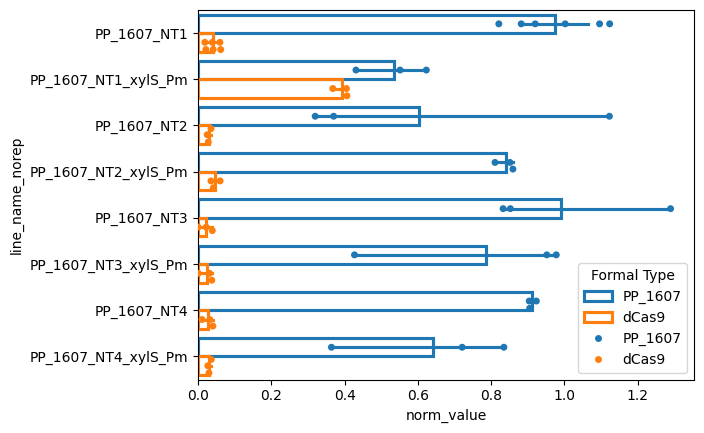

In [166]:
sns.barplot(
    data = df2.loc[(df2['Formal Type'].isin([ 'dCas9', 'PP_1607'])) & (df2['line_name_norep'].str.contains('1607')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    fill = False
)
sns.swarmplot(
    data = df2.loc[(df2['Formal Type'].isin([ 'dCas9', 'PP_1607'])) & (df2['line_name_norep'].str.contains('1607')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    dodge = True
)

<Axes: xlabel='norm_value', ylabel='line_name_norep'>

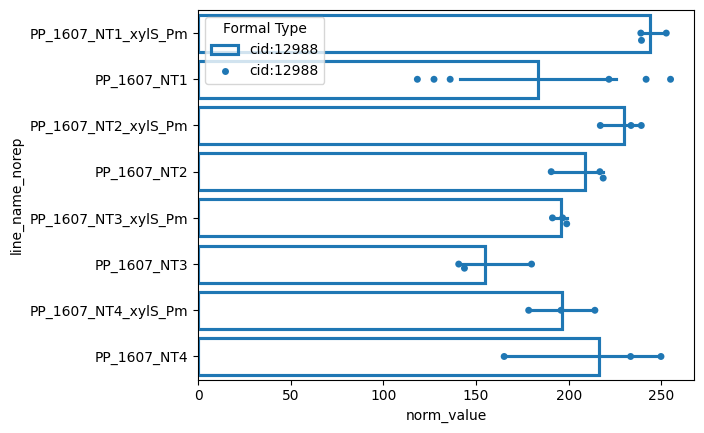

In [167]:
sns.barplot(
    data = df2.loc[(df2['Formal Type'].isin(['cid:12988'])) & (df2['line_name_norep'].str.contains('1607')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    fill = False
)
sns.swarmplot(
    data = df2.loc[(df2['Formal Type'].isin(['cid:12988'])) & (df2['line_name_norep'].str.contains('1607')), :],
    x = 'norm_value',
    y = 'line_name_norep',
    hue = 'Formal Type',
    dodge = True
)

In [185]:
df2.loc[df2['Target'] == 'PP_4194']['Line Name'].unique()

array(['PP_4194_NT2-R1', 'PP_4194_NT2-R2', 'PP_4194_NT2-R3',
       'PP_4194_NT3-R1', 'PP_4194_NT3-R2', 'PP_4194_NT3-R3'], dtype=object)

In [182]:
df_pivot = pd.pivot(
    data=df2,
    index = 'Line Name',
    columns = 'Formal Type',
    values= 'norm_value'
)
df_pivot

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,cid:12988,dCas9
Line Name,,,,,,,,,,,,,,,,,,,,,
Control-R1,1.056168,0.803228,0.954477,1.162171,1.180233,1.236426,1.327605,5.198323,0.943720,1.502085,...,0.997609,0.882987,2.088548,1.082902,1.044124,1.063733,1.097967,1.306628,177.33700,1.007405
Control-R10,1.094915,0.734310,2.293949,1.042917,0.971242,1.208610,0.993867,0.000000,0.837730,0.000000,...,0.985625,0.684557,0.000000,0.937894,1.081294,0.792854,0.952586,1.086405,176.13507,1.275427
Control-R11,0.771961,0.903685,0.113988,0.963285,0.930400,0.936830,0.951052,0.189451,1.113136,1.618171,...,1.014923,0.999426,0.206798,0.977893,0.909682,0.872016,1.053211,0.781209,192.63713,1.095618
Control-R12,1.242484,1.139102,2.295239,1.027043,1.030781,1.058569,1.194473,0.000000,1.140079,0.000000,...,0.989894,0.991785,2.819529,1.288799,0.874529,0.890724,0.955814,1.060845,202.70480,1.179865
Control-R13,1.051552,1.303006,1.158215,1.132820,1.021694,1.094537,1.269560,1.905220,1.087355,1.540679,...,0.999120,0.884202,0.196894,1.062889,1.236691,1.008304,1.037332,1.206203,123.84653,0.819190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2,1.079450,1.273056,1.085294,0.984512,0.832886,0.597834,0.980047,0.242375,0.116588,12.558807,...,0.790995,2.152656,6.560779,0.995223,0.890970,0.630470,0.871891,0.024475,370.25140,0.036465
PP_5419-R3,1.111790,1.345635,0.909980,1.120279,1.020815,0.064666,0.954257,2.127782,0.289805,12.608488,...,0.847534,1.652060,2.355039,1.102140,0.778892,0.596430,0.767842,0.024909,412.20373,0.037112
PP_5420-R1,1.104894,1.095924,3.502098,1.128739,0.893346,0.065886,1.039175,0.058301,0.271291,11.780818,...,0.507039,0.714045,1.125554,0.239940,0.960941,0.726382,0.892056,0.010848,84.91467,0.030160


In [180]:
df_pivot.to_csv('dbtl0_pivot_for_david.csv')

## Pivot 